In [1]:
import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install scipy
!{sys.executable} -m pip install pymc3

You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import pymc3 as pm
from functions import generate_simulation_data, plot_posteriors

<p class="gap2">
<h1 style="font-weight: bold; color: #ed9041">The Causal Problem of Overexposure to Repetitive Ads<br>
</h1>

<h2 style="color: #667b83">Instrument Variables and PyMC3</h2>


<p class="gap05">  </p>
<h3 style="color: #459db9">Ruben Mak <br>
Principal Data Scientist and Discovery Cluster Lead at Greenhouse</h3>
<img src="images/pydata_eindhoven.jpeg">
</p>

## Short introduction

<p><img src="images/wpp_greenhouse.png"></p>

## Quickly some terminology
* impression: an ad is loaded once onto a webpage browsed by a user

* conversion: the desired outcome of an advertiser, for example online purchase or visiting a specific webpage on the advertiser's website

* frequency cap: a setting which determines the maximum amount of impressions a user can get of an ad

## Research question
* What is the optimal amount of impressions per user to maximize conversions?

## What does the data say?

<p><img src="images/optimum_plots.png"></p>

## Maybe we should draw a causal graph...

<p><img src="images/causal_graph_1.png"></p>

## Maybe we should draw a causal graph...

<p><img src="images/causal_graph_2.png"></p>

## Instrumental Variable Setup
* The golden standard, A/B test (Random Controlled Trial) doesn't work...

* But we can run a A/B/n test on the frequency cap.

* This is a perfect setting to apply instrumental variables!

## Let's complete our causal graph

<p><img src="images/causal_graph_3.png"></p>

## Research question
* What is the optimal amount of impressions to maximize conversions?

* Do we really need instrumental variables, or are we looking for the results of the A/B test instead?

In [3]:
max_cap = 7
max_impr = 7

base_conversion_probability = [0.015, 0.07, 0.07, 0.08, 0.125, 0.08, 0.04]
effects = [0.1, 0.06, 0.04, 0.025, 0.015, 0.01, 0.005]

P_potential_impressions = [0.27, 0.21, 0.19, 0.14, 0.08, 0.06, 0.05]
P_frequency_cap = [1 / max_cap] * max_cap

n_users = 10 ** 6

df = generate_simulation_data(P_potential_impressions,
                            P_frequency_cap,
                            base_conversion_probability,
                            effects,
                            n_users)

df['non_conversions'] = df['users'] - df['conversions']

In [4]:
df

users  conversions  non_conversions
frequency_cap impressions                                      
1             1            143036        22920           120116
2             1             38653         4398            34255
              2            103924        24691            79233
3             1             38460         4441            34019
              2             29907         6762            23145
              3             74372        20714            53658
4             1             38329         4526            33803
              2             29952         6852            23100
              3             27145         7321            19824
              4             47408        14757            32651
5             1             38549         4381            34168
              2             29923         6854            23069
              3             27052         7132            19920
              4             20099         6239            13860
              5             27027         8842            18185
6             1             38522         4440            34082
              2             30001         6833            23168
              3             27097         7445            19652
              4             20176         6277            13899
              5             11484         4209             7275
              6             15783         4830            10953
7             1             38404         4280            34124
              2             30114         6920            23194
              3             27428         7352            20076
              4             19863         6029            13834
              5             11449         4146             7303
              6              8576         2830             5746
              7              7267         2152             5115

In [5]:
df_impressions = df.groupby(['impressions']).sum()
df_impressions

,users,conversions,non_conversions
impressions,,,
1,373953,49386,324567
2,253821,58912,194909
3,183094,49964,133130
4,107546,33302,74244
5,49960,17197,32763
6,24359,7660,16699
7,7267,2152,5115


In [6]:
df_frequency_cap = df.groupby(['frequency_cap']).sum()
df_frequency_cap

,users,conversions,non_conversions
frequency_cap,,,
1,143036,22920,120116
2,142577,29089,113488
3,142739,31917,110822
4,142834,33456,109378
5,142650,33448,109202
6,143063,34034,109029
7,143101,33709,109392


## Single treatment single instrument calculation

<h1><center>$\beta = \frac{P(Y=1|Z=1)-P(Y=1|Z=0)}{P(X=1|Z=1)-P(X=1|Z=0)}$</center></h1>


## Calculation example

<p><img src="images/causal_graph_4.png"></p>

## Adjusted calculation

<h1><center>$\beta_i = \frac{P(Y=1|Z=i)-P(Y=1|Z=i-1)}{P(X=i|Z=i)-P(X=i|Z=i-1)}$</center></h1>

<h1><center>$P(X=i|Z=i-1) = 0$</center></h1>

<h1><center>$\beta_i = \frac{P(Y=1|Z=i)-P(Y=1|Z=i-1)}{P(X=i|Z=i)}$</center></h1>

<h2><center>$\delta_i = P(Y=1|Z=i)-P(Y=1|Z=i-1)$</center></h2>

<h1><center>$\beta_i = \frac{\delta_i}{P(X=i|Z=i)}$</center></h1>

In [7]:
n_samples = 10 ** 4

P_Y_given_X = [stats.beta.rvs(
    df_impressions['conversions'][i],
    df_impressions['non_conversions'][i],
    size = n_samples) for i in df_impressions.index]

P_Y_given_Z = [stats.beta.rvs(
    df_frequency_cap['conversions'][i],
    df_frequency_cap['non_conversions'][i],
    size = n_samples) for i in df_frequency_cap.index]

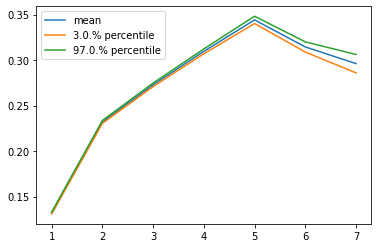

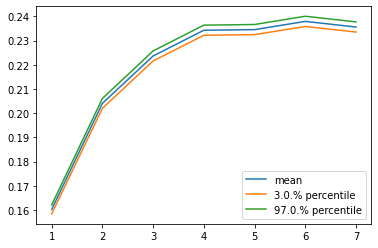

In [8]:
plot_posteriors(df_impressions.index, P_Y_given_X)
plot_posteriors(df_frequency_cap.index, P_Y_given_Z)

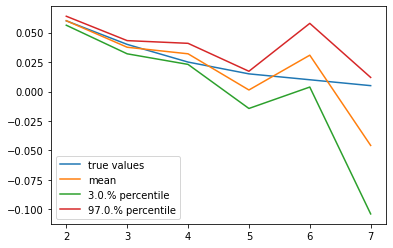

In [9]:
𝛿_P_Y_given_Z = [P_Y_given_Z[i] - P_Y_given_Z[i-1] 
                  for i in range(1, len(P_Y_given_Z))]

a = [df.loc[(i, i)].users for i in df_frequency_cap.index]
b = [df_frequency_cap.users[i+1] - a[i] 
     for i in range(len(a))]

P_X_given_Z = [stats.beta.rvs(a[i], b[i], size = n_samples) 
               for i in range(1, len(a))]

𝛽_effects = [𝛿_P_Y_given_Z[i] / P_X_given_Z[i] 
              for i in range(len(𝛿_P_Y_given_Z))]

plot_posteriors(df_frequency_cap.index[1:], 𝛽_effects, effects[1:])

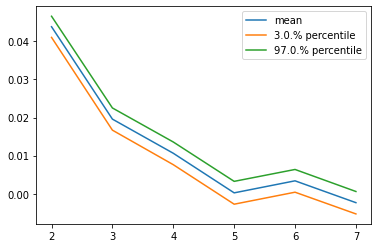

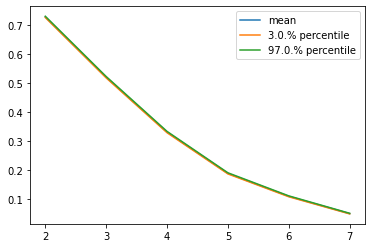

In [10]:
plot_posteriors(df_frequency_cap.index[1:], 𝛿_P_Y_given_Z)
plot_posteriors(df_frequency_cap.index[1:], P_X_given_Z)

## Making Assumptions
* Core of modelling: variance / bias trade-off

* Let's make some assumptions on a parametric for for $\delta_i$

## Define our model

<h1><center>
    $Y \sim $Binomial$(U, P(Y|Z)$<br>
    $P(Y|Z) = \alpha $logistic$(c + \theta Z)$<br>
    $\alpha \sim $HalfNormal$(0.25)$<br>
    $c \sim $Normal$(0, 3)$<br>
    $\theta \sim $HalfNormal$(0.5)$<br>
</center></h1>

In [ ]:
with pm.Model() as model_1:
    c = pm.Normal('c', mu=0, sigma=3)
    𝛼 = pm.HalfNormal('𝛼', sigma=0.25)
    𝜃 = pm.HalfNormal('𝜃', sigma=0.5)
    p = pm.Deterministic('p', 
                         𝛼 * pm.math.invlogit(c + 𝜃 * df_frequency_cap.index))
    conversion = pm.Binomial('conversion', 
                             df_frequency_cap.users, 
                             p, 
                             observed=df_frequency_cap.conversions)
    model_1 = pm.sample(int(n_samples/4), tune=10000, chains=4, cores=4)
    pm.traceplot(model_1)

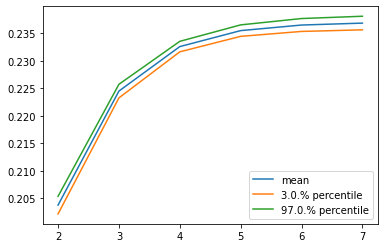

In [12]:
p_plot_1 = np.array(model_1['p']).T
plot_posteriors(df_frequency_cap.index[1:], p_plot_1[1:])

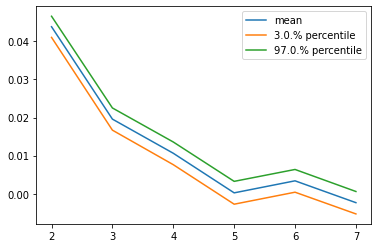

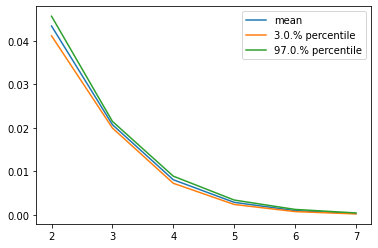

In [13]:
plot_posteriors(df_frequency_cap.index[1:], 𝛿_P_Y_given_Z)
𝛿_P_Y_given_Z_1 = [p_plot_1[i] - p_plot_1[i-1] 
                    for i in range(1, len(p_plot_1))]
plot_posteriors(df_frequency_cap.index[1:], 𝛿_P_Y_given_Z_1)

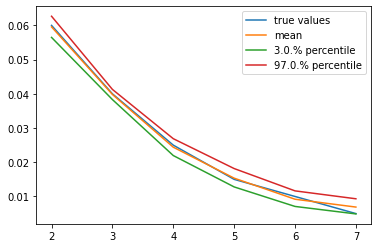

In [14]:
𝛽_effects_1 = [𝛿_P_Y_given_Z_1[i] / P_X_given_Z[i] 
                for i in range(len(𝛿_P_Y_given_Z))]

plot_posteriors(df_frequency_cap.index[1:], 𝛽_effects_1, effects[1:])

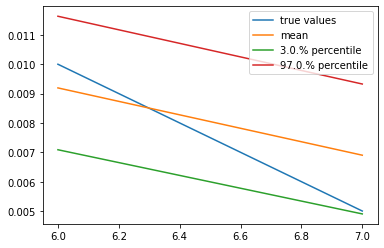

In [15]:
plot_posteriors(df_frequency_cap.index[5:7], 𝛽_effects_1[4:6], effects[5:7])

## Include hierarchy in our model

<h1><center>
    $Y \sim $Binomial$(U, P(Y|Z)$<br>
    $P(Y|Z) = \alpha $logistic$(c_Z + \theta Z)$<br>
    $\alpha \sim $HalfNormal$(0.25)$<br>
    $c \sim $Normal$(0, 3)$<br>
    $\sigma_c \sim $HalfNormal$(0, 0.2)$<br>
    $c_Z \sim $Normal$(c, \sigma_c)$<br>
    $\theta \sim $HalfNormal$(0.5)$<br>
</center></h1>

In [ ]:
with pm.Model() as model_2:
    c = pm.Normal('c', mu=0, sigma=3)
    𝜎_c = pm.HalfNormal('𝜎_c', sigma=0.2)
    c_Z = pm.Normal('c_Z', mu=c, sigma=𝜎_c, shape=max_cap)
    𝛼 = pm.HalfNormal('𝛼', sigma=0.16)
    𝜃 = pm.HalfNormal('𝜃', sigma=0.5)
    p = pm.Deterministic('p', 
                         𝛼 * pm.math.invlogit(c_Z[range(max_impr)] + 𝜃 * df_frequency_cap.index))
    conversion = pm.Binomial('conversion', 
                             df_frequency_cap.users, 
                             p, 
                             observed=df_frequency_cap.conversions)
    model_2 = pm.sample(int(n_samples/4), tune=10000, chains=4, cores=4)
    pm.traceplot(model_2)

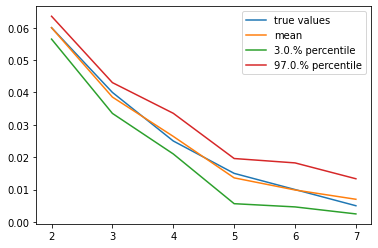

In [17]:
p_plot_2 = np.array(model_2['p']).T
𝛿_P_Y_given_Z_2 = [p_plot_2[i] - p_plot_2[i-1] 
                    for i in range(1, len(p_plot_2))]
𝛽_effects_2 = [𝛿_P_Y_given_Z_2[i] / P_X_given_Z[i] 
                for i in range(len(𝛿_P_Y_given_Z_2))]

plot_posteriors(df_frequency_cap.index[1:], 𝛽_effects_2, effects[1:])

## Recap: when to use instrumental variables
* You need to have unbiased estimates of causal effects

* You can't A/B test the treatment of interest

* You can run an A/B test something that influences the treatment of interest, but not the outcome directly

* You're sure you don't just need the results of the A/B tests

## Conclusion
* Instrumental variables can be applied to quite specific setups

* Unbiased estimates of causal effects for something you can't A/B test

* When you run into problems with variance, you can start modelling by making parametric assumptions

* Hierachical modelling can be used to soften assumptions, using PyMC3

## Questions?

In [ ]:
!jupyter nbconvert instrumental_variable_frequency_cap.ipynb --to slides --post serve

[NbConvertApp] Converting notebook instrumental_variable_frequency_cap.ipynb to slides
[NbConvertApp] Writing 460519 bytes to instrumental_variable_frequency_cap.slides.html
[NbConvertApp] Redirecting reveal.js requests to https://cdnjs.cloudflare.com/ajax/libs/reveal.js/3.5.0
Serving your slides at http://127.0.0.1:8000/instrumental_variable_frequency_cap.slides.html
Use Control-C to stop this server
